In [ ]:
!pip install unidecode
!pip install contractions
!pip install langdetect
!pip install yake
!python -m spacy download en_core_web_sm
!pip install bertopic
!pip install pipreqs
# # !pip install pyLDAvis

# Probelm Statement:


it is estimated that up to 90% of the world's data is unstructured meaning that it is built specifically for human consumption rather than for machines and that's great for us but it's also kind of difficult to organize or cluster all of that data it is quite simply impossible. There are techniques that allow us to actually understand the text. In machine learning clustering data is referred to as topic modelling is the automatic clustering of data into particular topics what this report is about. This report, a high-level view of the data pre-processing, then it also performs topic modelling on uncleaned data, manually cleaned data and machine-cleaned data.

This report perform two tasks on the LinkedIn dataset. The dataset contains the following attributes:  


1.   **postUrl**: URL of the LinkedIn Post
2.   **action**: Post or repost
3.   **type**:  Type of posted post. e.g., Article, Image, Video (LinkedIn Source), Poll,Video (External Source), Slideshow, Text
4.   **postContent**: actual post text
5.   **likeCount**: number of likes on the post
6.   **commentCount**: number of comments on the post



***Task 1: Decrypt the Post Date***
The postDate is encrypted in the postUrl attribute using a 19-digit activity code. This report perform a series of steps to decrypt the postDate from the postUrl.

***Task 2: Contextual Topic Modelling***
This report utilized a contextual topic modeling technique (BERTopic and LDA) on the postContent attribute to cluster the posts into 10 different topic clusters. Additionally, This report visualize the average engagement of each topic cluster, where engagement is defined as the sum of likeCount and commentCount.


This report gets into the details of BERTopic and explains transformer embedding, a UMAP for dimensionality reduction, HDBScan for clustering, and CTF-IDF extracting topics from LinkedIn dataset. This report also explains how our understanding of these different components allows us to improve topic modelling achieve Task_2.

## Import Libraries

In [2]:
#Python
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra


#EDA
from langdetect import detect
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Keyphrase Extraction
import yake


#Preprocessing

#date extraction
import datetime as dt
from pytz import all_timezones
import re

#data cleaning
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
import contractions
from unidecode import unidecode
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, LancasterStemmer


#Feature Engineering
#Gensim
import gensim
import gensim.corpora as corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#spacy
import spacy
import scipy.sparse

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel


#customBERT

#dimensionality reduction
from umap import UMAP
from sklearn.decomposition import PCA

 #clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

#word/sentence embedding
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

#BERTopic
from bertopic import BERTopic

# #vis
# import pyLDAvis
# import pyLDAvis.gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load Dataset

In [4]:
df_main = pd.read_csv('test_data.csv')
df_main.head()

,postUrl,action,type,postContent,likeCount,commentCount
0,https://www.linkedin.com/feed/update/urn:li:ac...,Post,Article,"Personalized learning, inclusive environments,...",2158,212
1,https://www.linkedin.com/feed/update/urn:li:ac...,Post,Article,It's fascinating to see how much we can still ...,1326,131
2,https://www.linkedin.com/feed/update/urn:li:ac...,Post,Article,AI is the most transformative technology any o...,7254,360
3,https://www.linkedin.com/feed/update/urn:li:ac...,Post,Article,"While AI will impact jobs, it can also enhance...",3596,245
4,https://www.linkedin.com/feed/update/urn:li:ac...,Post,Image,I’m really excited about my new podcast. Join ...,3767,154


Loaded the dataset files with csv extension from the dataset folder.

In [5]:
df = df_main.copy()

Create a copy of the main dataset for backup.

## Data Preprocessing

### Task 1: Decrypt the Post Date:

To decrypt the postDate from the postUrl, Following steps need to perform:

In [6]:
#checking for null values
df.isnull().sum()

postUrl          0
action           0
type             0
postContent     20
likeCount        0
commentCount     0
dtype: int64

In [7]:
df.dropna(inplace=True)


**Step 1: Extract the Last Digit from the postUrl**


The last digits from the link is the 19th digit in the activity code.


In [8]:
df['activity_code'] = df['postUrl'].str.findall('[0-9]{19}').str.join(",")
df['activity_code']

0      7086118852786356224
1      7085672835347611648
2      7085373480338157568
3      7084600751930408960
4      7084211415196053505
              ...         
842    5984800525680390144
844    5984073880724062208
859    5842379637677629440
862    5823534106230657024
864    5813809600503222272
Name: activity_code, Length: 846, dtype: object

**Step 2: Convert Decimal to Binary**


Below step will convert the 19-digit decimal activity code to a binary representation.

In [9]:
df['binary_activity_code'] = df.iloc[:,6].apply(lambda i: format(int(i), '04b'))
df['binary_activity_code']

0      1100010010101101111001110001101100000001000011...
1      1100010010101010101110111100110111110011000011...
2      1100010010101000100110110100011111101001000011...
3      1100010010100011000111011011001000110100100011...
4      1100010010100000010110010111111100101001000011...
                             ...                        
842    1010011000011100100100001011110100010001100000...
844    1010011000010111011001101111101010100100100000...
859    1010001000101000100110101010011100000101100000...
862    1010000110100010101100101101010010010110100000...
864    1010000101011101100110100000111010111011100000...
Name: binary_activity_code, Length: 846, dtype: object

**Step 3: Extract Unix Timestamp**


The first 41 bits(mostleft bits) of the binary representation represent the Unix timestamp.

In [10]:
df['unix_timestamp'] = df['binary_activity_code'].apply(lambda i: int(i[:41], 2))
df['unix_timestamp']

0      1689462388226
1      1689356049382
2      1689284677586
3      1689100444777
4      1689007619666
           ...      
842    1426887637539
844    1426714391881
859    1392931851787
862    1388438726957
864    1386120224119
Name: unix_timestamp, Length: 846, dtype: int64

**Step 4: Convert Unix Timestamp to Human-Readable Date**


Below step will obtained the human-readable postDate from the Unix timestamp. Here, it is important understand that, Berlin time_zone has selected for the convince.

In [11]:
df['human_readable_postDate'] = pd.to_datetime(df['unix_timestamp'], unit = 'ms')

df['postDate_Berlin_TZ'] = df['human_readable_postDate'].dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin').dt.strftime('%d-%B-%Y %H:%M:%S')
df['postDate_Berlin_TZ']

0          16-July-2023 01:06:28
1          14-July-2023 19:34:09
2          13-July-2023 23:44:37
3          11-July-2023 20:34:04
4          10-July-2023 18:46:59
                 ...            
842       20-March-2015 22:40:37
844       18-March-2015 22:33:11
859    20-February-2014 22:30:51
862    30-December-2013 22:25:26
864    04-December-2013 02:23:44
Name: postDate_Berlin_TZ, Length: 846, dtype: object

Below step detect the language of the corpus.

In [12]:
def lang_detect(data):
    detected_lang = detect(data)
    return detected_lang

df['language'] = df['postContent'].apply(lang_detect)
df['language'].value_counts()

en    846
Name: language, dtype: int64

As per above step, all of the text is written in english (en) language. Hence,no need for language translation for this task.

In [13]:
#dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846 entries, 0 to 864
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   postUrl                  846 non-null    object        
 1   action                   846 non-null    object        
 2   type                     846 non-null    object        
 3   postContent              846 non-null    object        
 4   likeCount                846 non-null    int64         
 5   commentCount             846 non-null    int64         
 6   activity_code            846 non-null    object        
 7   binary_activity_code     846 non-null    object        
 8   unix_timestamp           846 non-null    int64         
 9   human_readable_postDate  846 non-null    datetime64[ns]
 10  postDate_Berlin_TZ       846 non-null    object        
 11  language                 846 non-null    object        
dtypes: datetime64[ns](1), int64(3), obje

Below step helps to compute Average Engagement for Each Topic Cluster by doing the summation of likeCount and commentCount to get the engagement score.

In [14]:
df['engagement'] = df['likeCount']+df['commentCount']

Further step helps to delete unwanted columns as per listed in list.

In [15]:
delete_colms = ['postUrl', 'action', 'likeCount', 'commentCount', 'activity_code', 'binary_activity_code', 'unix_timestamp', 'human_readable_postDate', 'language']
df.drop(delete_colms, axis = 1, inplace = True)

df['year'] = pd.DatetimeIndex(df['postDate_Berlin_TZ']).year
df.head()

,type,postContent,postDate_Berlin_TZ,engagement,year
0,Article,"Personalized learning, inclusive environments,...",16-July-2023 01:06:28,2370,2023
1,Article,It's fascinating to see how much we can still ...,14-July-2023 19:34:09,1457,2023
2,Article,AI is the most transformative technology any o...,13-July-2023 23:44:37,7614,2023
3,Article,"While AI will impact jobs, it can also enhance...",11-July-2023 20:34:04,3841,2023
4,Image,I’m really excited about my new podcast. Join ...,10-July-2023 18:46:59,3921,2023


Above steps extract the year from postDate for Task_2.

In [16]:
print('No. of Rows: ',df.shape[0])
print('No. of Columns: ',df.shape[1])

No. of Rows:  846
No. of Columns:  5


As per dataset, 846 text records are present, however this report is concerned about the text records posted on LinkedIn after January 2021.

In [17]:
df_1 = df.loc[(df['year']) >= 2021]
df.head()

,type,postContent,postDate_Berlin_TZ,engagement,year
0,Article,"Personalized learning, inclusive environments,...",16-July-2023 01:06:28,2370,2023
1,Article,It's fascinating to see how much we can still ...,14-July-2023 19:34:09,1457,2023
2,Article,AI is the most transformative technology any o...,13-July-2023 23:44:37,7614,2023
3,Article,"While AI will impact jobs, it can also enhance...",11-July-2023 20:34:04,3841,2023
4,Image,I’m really excited about my new podcast. Join ...,10-July-2023 18:46:59,3921,2023


In [18]:
df = df_1.copy()
print('New dataframe with the posts from Jan 2021 onwards')
print('No. of Rows: ',df.shape[0])
print('No. of Columns: ',df.shape[1])

New dataframe with the posts from Jan 2021 onwards
No. of Rows:  501
No. of Columns:  5


Hence, above step filter out and create a dataframe of the data records published on and after 2021 i.e., 501 rows

## Task_2: Contextual Topic modelling

In [19]:
def remove_hyperlink(data):

  """
  This function identify and remove URLs or any other website link
  using regular expressions. As these links do not contribute to
  contextual topic modeling and can be safely removed.
  """
  pattern =  r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  removed_hyplink = re.sub(pattern, '  ', data)
  return removed_hyplink


def remove_space(data):

  """
  This step helps in standardizing the text
  and avoids inconsistencies due to extra spaces.
  Trim and replace multiple consecutive white spaces,
  blank spaces, and tabs with a single space.
  """
  removed_space = data.replace('\\n','').replace('\\',' ').replace('\t',' ')
  return removed_space


def expand_text(data):

  """
  Contractions means the text to their full forms.
  For example, "don't" should be expanded to "do not."
  This function ensures that words with contractions are
  properly represented in the text by expanding them.
  And such expanded words can be handled
  effectively during tokenization and analysis.
  """
  expanded_text = contractions.fix(data)
  return expanded_text


def accented_word(data):

  """
  If the data contains accented characters,
  normalize them to their ASCII equivalents.
  e.g., 'à, è, ì, ò, ù, À, È, Ì, Ò, Ù' such words are
  converted into a, e, i, o, u, A, E, I, O, U.
  This process ensures consistency and prevents encoding issues during tokenization.
  """
  remove_acceted_text = unidecode(data)
  return remove_acceted_text


stopword_list = stopwords.words('english')
domain_stop_words = ['one', 'much', 'like', 'not', 'new', 'life',
                     'make', 'need', 'change', 'good', 'next', 'would']
stopword_list.extend(domain_stop_words)


def clean_data(data):

  """
  Stopwords: Use a predefined list of language-specific stopwords
  (e.g., "the," "is," "and", etc.) and domain-specific stopwords
  (specific to LinkedIn posts) to remove irrelevant
  and commonly occurring words that do not contribute much to topic modeling.

  Word Tokenization:Tokenize the preprocessed text into individual words.
  This process divides the text into meaningful units for further analysis.

  Remove Punctuation: Remove all punctuation marks
  (e.g., !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~) from the text.
  Punctuation often does not carry significant meaning for topic modeling
  and can be safely discarded.

  Text Normalization: Convert all tokens to lowercase.
  This step ensures that words in different cases (e.g., "Hello" and "hello")
  are considered the same during analysis,
  preventing multiple vector representations of the same words.

  Selecting Only Alphabets:
  Remove any non-alphabetic characters (numbers, special symbols) from the text.
  This step helps to keep only words relevant to topic modeling and
  discard any numeric or symbolic noise.
  """

  tokens = word_tokenize(data)
  cleaned_text = [word.lower() for word in tokens if (word not in punctuation) and (word.lower() not in stopword_list) and (word.isalpha()) and len(word)>=2 ]
  return cleaned_text

def lemmatization(data):

  """
  Word Lemmatization: Lemmatize the words to their base or root form.
  (e.g., "running" to "run") to ensure that variations of the same word are consolidated,
  providing a clearer view of word frequencies.
  """

  lemmatizer = WordNetLemmatizer()
  final_data = []

  for word in data:
    lemmatizer_word = lemmatizer.lemmatize(word)
    final_data.append(lemmatizer_word)
  return ' '.join(final_data)

In [20]:
df['cleaned_postContent'] = df['postContent'].apply(remove_hyperlink)

df['cleaned_postContent'] = df['cleaned_postContent'].apply(remove_space)

df['cleaned_postContent'] = df['cleaned_postContent'].apply(expand_text)

df['cleaned_postContent'] = df['cleaned_postContent'].apply(accented_word)

df['cleaned_postContent'] = df['cleaned_postContent'].apply(clean_data)

df['cleaned_postContent'] = df['cleaned_postContent'].apply(lemmatization)

## Exploratory Data Analysis (EDA)


Exploratory Data Analysis (EDA) is a crucial step in understanding the characteristics and patterns present in the LinkedIn corpus. This step help to gain insights into the postContent, identify trends, and determine the necessary preprocessing steps. Below are the EDA steps, including n-grams and trigrams, word cloud, and keyphrase extraction using the YAKE unsupervised algorithm:

### Trigrams:

n-grams and Trigrams:

N-grams are contiguous sequences of n words from a given text. For example, in the sentence "Please avoid climate disaster,"

1-grams (unigrams) are ['Please', 'avoid', 'climate', 'disaster'],

2-grams (bigrams) are ['Please avoid', 'avoid climate', 'climate disaster'], and

3-grams (trigrams) are ['Please avoid climate', 'avoid climate disaster'].


Analyzing n-grams and trigrams helps identify commonly occurring phrases or sequences of words in the LinkedIn post content. It can reveal meaningful collocations and provide insights into the most frequent combinations of words.

In [21]:
def ngrams_extractor(data, ngram_range):
    tokens = word_tokenize(data)
    ngram_text = ngrams(tokens, ngram_range)
    ngram_list = []

    for ngram in ngram_text:
        ngram_list.append(' '.join(ngram))
    return ngram_list

trigrams_df = df['cleaned_postContent'].apply(lambda i : ngrams_extractor(i,3))

final_trigram = []

for trigram in trigrams_df:
    final_trigram.extend(trigram)
count_trigram = Counter(final_trigram).most_common(10)
count_trigram

[('avoid climate disaster', 22),
 ('bill melinda gate', 16),
 ('melinda gate foundation', 16),
 ('breakthrough energy catalyst', 11),
 ('avoiding climate disaster', 6),
 ('worst effect climate', 5),
 ('greenhouse gas emission', 5),
 ('clean energy future', 4),
 ('clean energy transition', 4),
 ('northern arizona university', 4)]

### Wordcloud

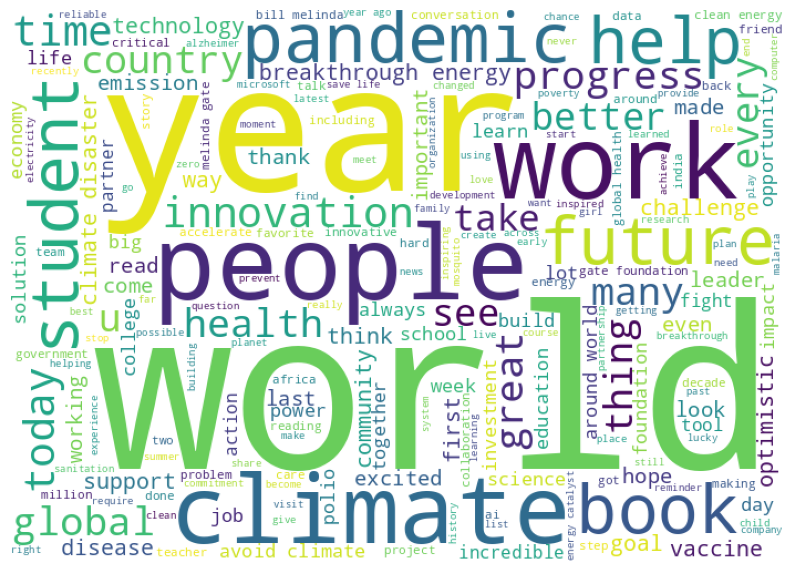

In [22]:
def wordcloud(data, column):

  """
  This function will get a visual representation of the most frequently
  occurring words in the text data, where the size of each word is
  proportional to its frequency. This function helps to
  quickly identify the most common words in the LinkedIn posts.
  This graphical representation gives an intuitive overview of
  the frequently mentioned topics and themes in the dataset.
  """

  df_ = data[column].str.cat(sep = ' ')
  text = ' '.join([word for word in df_.split()])

  wordcloud = WordCloud(width = 700, height = 500, background_color = 'white').generate(text)

  plt.figure(figsize = (10,15))
  plt.imshow(wordcloud)
  plt.axis('off')

wordcloud(df, 'cleaned_postContent')

### Keyphrase Extraction:

In [23]:
def yake_extractor(data):

  """
  This function write to code to extract keyphrase or keywords from corpus.
  YAKE (Yet Another Keyword Extractor) is an unsupervised algorithm
  used for keyphrase extraction from text data.
  This function will ranks and extracts important phrases from the content
  without the need for labeled training data.
  YAKE extracts keyphrases that represent the most
  salient topics and concepts in the LinkedIn post content.
  These keyphrases can be valuable for understanding the main themes
  discussed in the posts and for generating relevant tags or labels for the posts.
  """

  yake_kp_extractor = yake.KeywordExtractor()
  keywords = yake_kp_extractor.extract_keywords(data)
  keyword_list = []

  for kw in keywords:
    keyword_list.append(kw[0])

  return keyword_list

keywords = df['cleaned_postContent'].apply(yake_extractor)

final_keywords = []

for kw_ in keywords:
    final_keywords.extend(kw_)

count_keywords = Counter(final_keywords).most_common(10)
count_keywords

[('avoid climate disaster', 19),
 ('world', 16),
 ('bill melinda gate', 16),
 ('melinda gate foundation', 16),
 ('climate disaster', 15),
 ('book', 13),
 ('climate', 13),
 ('year', 12),
 ('avoid climate', 11),
 ('pandemic', 10)]

## Model Training

Choose a topic modeling technique such as BERTopic or Latent Dirichlet Allocation (LDA).

In [24]:
X_train = df['cleaned_postContent']
X_train.shape

(501,)

### BERTopic Model with RAW Data (Without manual pre-processing data)

In [25]:
topic_model_1 = BERTopic(calculate_probabilities=True)
topics_1, probs_1 = topic_model_1.fit_transform(df['postContent'])

In [26]:
topic_model_1.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,489,0_the_to_and_of,"[the, to, and, of, in, is, for, that, we, about]",[When I first started learning about climate c...
1,1,12,1_alzheimers_the_and_data,"[alzheimers, the, and, data, disease, to, diag...",[It’s hard to quantify the human cost of Alzhe...


In [27]:
topic_model_1.visualize_barchart()

### BERTopic model with customized parameters and pre-processed data

**BERTopic:**

BERTopic is based on BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art language representation model. BERT is designed to capture contextual information, which makes BERTopic suitable for understanding the semantic meaning and context of LinkedIn post content. It can handle complex linguistic structures, capturing relationships between words and phrases in the data. BERTopic allows for easy customization, such as specifying the number of topics and adjusting the clustering parameters. It also provides a representative sentence for each topic, making it easier to interpret and label the clusters.


**UMAP (Uniform Manifold Approximation and Projection):**

UMAP is used for dimensionality reduction. The Document-Term Matrix (DTM) contains a large number of columns for each token that can lead to a high-dimensional space. Hence, UMAP compresses this high-dimensional space into a lower-dimensional representation, preserving the local and global structure of the data. This reduction allows for better visualization and understanding of the data. UMAP is known for its efficiency in preserving data structure while being computationally faster than other dimensionality reduction techniques.


In [28]:
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer_model = CountVectorizer(ngram_range= (1,3), stop_words=stopword_list)
# umpa_model = UMAP(n_neighbors=5, n_components=3, min_dist=0.3)
# hdbscan_mode = HDBSCAN(min_cluster_size=80, min_samples=40,
#                        prediction_data=True, gen_min_span_tree=True)

dim_model = PCA(n_components=5)
cluster_model = KMeans(n_clusters=17)


topic_model_2 = BERTopic(embedding_model="allenai-specter",
                         umap_model=dim_model,
                         hdbscan_model=cluster_model,
                         top_n_words=10,
                         language='english',
                         calculate_probabilities=True,
                         verbose=True
                         )

In [29]:
topics_2, probs_2 = topic_model_2.fit_transform(X_train)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2023-07-31 11:42:06,896 - BERTopic - Transformed documents to Embeddings
2023-07-31 11:42:06,952 - BERTopic - Reduced dimensionality
2023-07-31 11:42:07,145 - BERTopic - Clustered reduced embeddings


Custom BERTopic Components:

Text can come in a lot of different formats like paragraph or sentence size chunks of text. and we typically call them documents.

A **sentence transformer model** is going to output for each document a single vector now this vector or this embedding is extremely high dimensional. Vector has a numerical representation of the meaning behind its respective document, so it is like translating human meaning into a machine meaning for each of these documents. Sentence transformers' typical dimension sizes are 768 dimensions or 384 dimensions (Mini Model). We need to do is compress the information within those vectors into a smaller space so for that we use UMAP.
word embeddings or sentence embeddings that we have just created 384 dimensional we cannot visualize them at the moment.


So, **UMAP** will allow us to compress those very high dimensional vectors into a smaller vector space like from 768 to 3d or 2d which can be useful. UMAP performs well with both local and global structures. the key parameter is the n_neighbors’ parameter which identifies the density of particular areas in our data by finding the k nearest neighbours. min_dis parameter limits how closely UMAP can put two points together so by default this is 0.1. Also, min samples allows us how dense the core of a cluster needs to be in order to
become a core of a cluster.

**c-TF-IDF** looks at the frequency of words within a particular topic. IDF part will assign a low score to the words that are quite common like “the, a”. It looks at how common these words are but if we have a rare word something like “Pandemic, atomic” it assigns a high score. Tokenizers create tokens which are words, and it is these tokens or terms that the CTF-IDF algorithm will make frequency and identify the most relevant ones. e.g., pandemic, vaccine pretty relevant to the infection.

In [30]:
topic_model_2.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,57,0_book_read_year_list,"[book, read, year, list, day, ai, look, every,...",[last decade written annual list great book re...
1,1,51,1_reading_great_lot_favorite,"[reading, great, lot, favorite, friend, summer...",[favorite holiday tradition sharing book famil...
2,2,41,2_foundation_work_polio_story,"[foundation, work, polio, story, world, talk, ...",[stunning hear polio york earlier year reminde...
3,3,40,3_pandemic_world_malaria_mosquito,"[pandemic, world, malaria, mosquito, progress,...",[innovation including vaccine antiviral save l...
4,4,39,4_climate_disaster_avoid_goal,"[climate, disaster, avoid, goal, people, emiss...",[first started learning climate year ago came ...
5,5,32,5_energy_clean_catalyst_hydrogen,"[energy, clean, catalyst, hydrogen, climate, b...",[avoiding climate disaster require industrial ...
6,6,32,6_life_health_education_girl,"[life, health, education, girl, community, car...",[today anniversary passing reflecting legacy p...
7,7,31,7_energy_climate_emission_carbon,"[energy, climate, emission, carbon, look, worl...",[world need many breakthrough get billion ton ...
8,8,26,8_school_teacher_student_year,"[school, teacher, student, year, computer, sta...",[growing seattle learned little area indigenou...
9,9,24,9_health_polio_global_country,"[health, polio, global, country, senegal, pove...",[uganda maternal mortality rate double global ...


In [31]:
topic_model_2.visualize_barchart(width = 250, height = 300, top_n_topics=10, n_words=5)

Topic formation is pretty good, however some of the words found in multiple topics. Will keep looking for other option.

#### Traditional Feature Engineering data on Latent Dirichlet allocation LDA)

In [32]:
count_vector = CountVectorizer(max_df=0.8,
                               min_df=5,
                               max_features=1800,
                               strip_accents = 'unicode',
                               stop_words='english',
                               lowercase=True)
count_vector.fit(X_train)
df_countvectorizer = count_vector.transform(X_train)

print('\ndf_countvectorizer  shape: ',df_countvectorizer.shape)
print('*'*100,)

df_bow = pd.DataFrame(df_countvectorizer.A, columns = count_vector.get_feature_names_out())
df_bow


df_countvectorizer  shape:  (501, 440)
****************************************************************************************************


,accelerate,access,accessible,achieve,achieving,act,action,adapt,address,addressing,...,worker,working,world,worst,worth,wrote,year,yesterday,young,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [33]:
tokenized_reviews_1 = [sent.split() for sent in X_train.tolist()]
dictionary_1 = corpora.Dictionary(tokenized_reviews_1)
doc_term_matrix_1 = [dictionary_1.doc2bow(rev) for rev in tokenized_reviews_1]
doc_term_matrix_1[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1)]

**Document-Term Matrix (DTM):**

LDA requires a numerical representation of the text data. The DTM provides a direct representation of text where rows represent documents (postContents), columns represent unique words, and the cells contain word frequencies or scores. This matrix serves as input to the LDA algorithm, enabling the modeling of topic distributions within the documents.

#### processed raw data (Spacy and gensim library) on Latent Dirichlet allocation (LDA)

In [34]:
allowed_postags=["NOUN", "VERB","ADJ", "ADV"]
pretrained_data_preprocessor = spacy.load("en_core_web_sm", disable=["parser", "ner"])

lemmatized_texts = []
for text in df['postContent']:
    docs = pretrained_data_preprocessor(text)
    processed_text = []
    for token in docs:
        if token.pos_ in allowed_postags:
            processed_text.append(token.lemma_)
    final = " ".join(processed_text)
    lemmatized_texts.append(final)

tokenized_reviews_2 = [gensim.utils.simple_preprocess(text, deacc=True) for text in lemmatized_texts]

dictionary_2 = corpora.Dictionary(tokenized_reviews_2)

doc_term_matrix_2 = [dictionary_2.doc2bow(text) for text in tokenized_reviews_2]
doc_term_matrix_2[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [35]:
def lda_model(num_topics, corpus, id2word, texts, titel):
    model = gensim.models.ldamodel.LdaModel(num_topics = num_topics,
                                            corpus = corpus,
                                            id2word = id2word,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            iterations=100,
                                            alpha="auto")

    perplexity = model.log_perplexity(corpus,total_docs=10000)  # a measure of how good the model is. lower the better.

    coherence_model_lda = CoherenceModel(model=model, dictionary=id2word, texts=texts,  coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    print(f'\nPerplexity of {titel} is {perplexity}: ', )
    print(f'\nCoherence Score of {titel} is {coherence_lda}: ', )

    return model

In [36]:
model_1 = lda_model(num_topics= 10,
                    corpus= doc_term_matrix_1,
                    id2word= dictionary_1,
                    texts = tokenized_reviews_1,
                    titel = 'Count_Vectorizer with manual data preprocessing')


Perplexity of Count_Vectorizer with manual data preprocessing is -7.508147078549792: 

Coherence Score of Count_Vectorizer with manual data preprocessing is 0.3579238666227792: 


In [37]:
model_2 = lda_model(num_topics= 10,
                    corpus= doc_term_matrix_2,
                    id2word= dictionary_2,
                    texts = tokenized_reviews_2,
                    titel = 'spacy gensim pre-trained data preprocessing')


Perplexity of spacy gensim pre-trained data preprocessing is -7.066032115257823: 

Coherence Score of spacy gensim pre-trained data preprocessing is 0.43535997992838593: 


Coherence score is used in evaluation metric for Latent Dirichlet Allocation (LDA). It quantifies the quality and interpretability of the preticted topics.

Topics with low coherence scores indicate ambiguous or poorly defined concepts, and it might be beneficial to revisit the preprocessing steps or adjust LDA parameters to improve the model's performance.

A higher coherence score suggests that the topic is more interpretable and represents a more distinct concept.

Based on this experiment, one of the finding is that LDA model produces better coherence score on spacy gensim pre-trained models i.e., 0.43

However, will keep looking for better score.

**LDA (Latent Dirichlet Allocation):**

LDA is a probabilistic generative model, It assumes that each document is a mixture of topics and each topic is a distribution of words. This inherent structure allows for human-understandable topics that can be labeled and interpreted more easily. LDA is computationally efficient and can handle large datasets with many documents and words. LinkedIn post content can be vast and diverse. LDA scales well with the number of topics, which makes it a good choice when aiming for a fixed number of clusters (in this case, 10 topic clusters).


### Hyperparameter Tunning

In [38]:
def compute_coherence_score(id2word, corpus, texts, start, stop, step_size):

    coherence_scores = []
    model_list = []
    for num_topics in range(start, stop, step_size):
        model = gensim.models.ldamodel.LdaModel(num_topics=num_topics,
                                                corpus=corpus,
                                                id2word= id2word,
                                                random_state=42,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                iterations=100,
                                                alpha="auto")
        model_list.append(model)

        coherence_model_lda = CoherenceModel(model=model, dictionary=id2word, texts=texts, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)

    return model_list, coherence_scores

model_list, coherence_scores = compute_coherence_score(id2word=dictionary_2,
                                                        corpus=doc_term_matrix_2,
                                                        texts = tokenized_reviews_2,
                                                        start=2,
                                                        stop=50,
                                                        step_size=1)

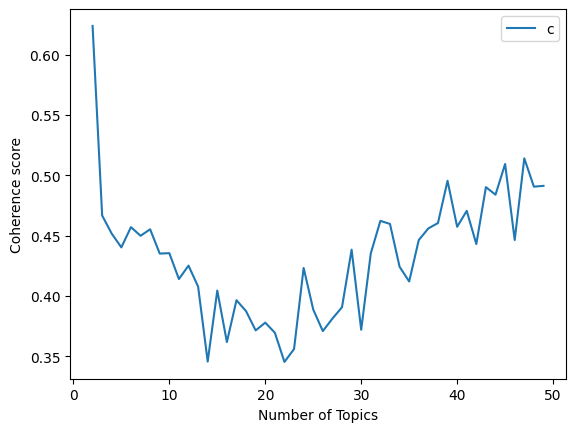

In [39]:
start=2; stop=50; step_size=1;

x = range(start, stop, step_size)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
for topic, cohren_valu in zip(x, coherence_scores):
    print("Number of Topics =", topic, " has Coherence score: ", round(cohren_valu, 3))

Number of Topics = 2  has Coherence score:  0.624
Number of Topics = 3  has Coherence score:  0.467
Number of Topics = 4  has Coherence score:  0.451
Number of Topics = 5  has Coherence score:  0.44
Number of Topics = 6  has Coherence score:  0.457
Number of Topics = 7  has Coherence score:  0.45
Number of Topics = 8  has Coherence score:  0.455
Number of Topics = 9  has Coherence score:  0.435
Number of Topics = 10  has Coherence score:  0.435
Number of Topics = 11  has Coherence score:  0.414
Number of Topics = 12  has Coherence score:  0.425
Number of Topics = 13  has Coherence score:  0.408
Number of Topics = 14  has Coherence score:  0.345
Number of Topics = 15  has Coherence score:  0.404
Number of Topics = 16  has Coherence score:  0.362
Number of Topics = 17  has Coherence score:  0.396
Number of Topics = 18  has Coherence score:  0.387
Number of Topics = 19  has Coherence score:  0.371
Number of Topics = 20  has Coherence score:  0.378
Number of Topics = 21  has Coherence scor

Based on the above hyperparameter step, Best Coherence score is found between cluster size of 40-50, however practically this can be considered, but for this taks to make it simplified, it is advised to take cluster less than 10. Hence, model with 8 cluster provide coherence score 0.455 can be consider.

In [41]:
best_model = model_list[8]
best_model.print_topics(num_words=5)

[(0,
  '0.246*"plan" + 0.030*"hope" + 0.025*"book" + 0.025*"end" + 0.014*"write"'),
 (1,
  '0.023*"re" + 0.020*"list" + 0.014*"coalition" + 0.010*"machine" + 0.009*"drive"'),
 (2,
  '0.034*"new" + 0.023*"next" + 0.018*"disease" + 0.016*"technology" + 0.016*"make"'),
 (3,
  '0.028*"life" + 0.025*"student" + 0.020*"more" + 0.019*"vaccine" + 0.019*"net"'),
 (4,
  '0.094*"other" + 0.053*"climate" + 0.050*"country" + 0.049*"lead" + 0.049*"action"'),
 (5,
  '0.098*"many" + 0.093*"ve" + 0.087*"check" + 0.084*"put" + 0.065*"learn"'),
 (6,
  '0.180*"take" + 0.095*"emission" + 0.088*"start" + 0.084*"path" + 0.074*"good"'),
 (7,
  '0.029*"climate" + 0.027*"people" + 0.022*"world" + 0.022*"get" + 0.021*"need"'),
 (8,
  '0.045*"pandemic" + 0.027*"innovation" + 0.018*"investment" + 0.017*"covid" + 0.016*"malaria"'),
 (9,
  '0.060*"in" + 0.060*"lnkd" + 0.058*"https" + 0.013*"lucky" + 0.012*"visit"')]

## Final Best Model

In [42]:
topic_model_3 = BERTopic(calculate_probabilities=True)
topics_3, probs_3 = topic_model_3.fit_transform(X_train)

2023-07-31 11:45:13,369 - BERTopic - Transformed documents to Embeddings
2023-07-31 11:45:16,308 - BERTopic - Reduced dimensionality
2023-07-31 11:45:16,343 - BERTopic - Clustered reduced embeddings


So, it is not perfect there are some outliers that we would like to be in there but quite a few of those outliers are there that we do not want in there.

-1 in the topic is where that data doesn't seem to fit into any of the clusters that the topic has identified so it's an outlier. Likewise this step has 109 documents that are outliers or cannot classify thier topic. This experiment has overall 9 topic cluster for this corpus.

In [43]:
topic_model_3.save("final_model", serialization="pickle")
# loaded_model = BERTopic.load("final_model")

In [44]:
topic_model_3.visualize_barchart(width = 250, height = 300, top_n_topics=10, n_words=5)

topics 4 and 7 are similar topics, better to merge them

In [ ]:
# topic_model_3.merge_topics(X_train, topics_to_merge=[4,6])
# topic_model_3.visualize_barchart(width = 250, height = 300, top_n_topics=10, n_words=5)

In [45]:
topic_model_3.visualize_heatmap(n_clusters=7)

In [46]:
topic_model_3.visualize_hierarchy()

In [47]:
topic_model_3.visualize_distribution(probs_3[1])

In [48]:
topic_labels = topic_model_3.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=15, separator= '-')
topic_model_3.set_topic_labels(topic_labels)
topic_model_3.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,109,-1_world_health_people_india,world-health-people,"[world, health, people, india, global, time, s...",[prime minister shinzo abe understood improvin...
1,0,122,0_climate_energy_clean_breakthrough,climate-energy-clean,"[climate, energy, clean, breakthrough, emissio...",[grateful joined boris johnson today highlight...
2,1,85,1_pandemic_vaccine_world_malaria,pandemic-vaccine-world,"[pandemic, vaccine, world, malaria, life, glob...",[goal pandemic ever ambitious world progress p...
3,2,42,2_student_teacher_school_college,student-teacher-school,"[student, teacher, school, college, black, yea...",[black student learn computer science high sch...
4,3,37,3_foundation_gate_melinda_warren,foundation-gate-melinda,"[foundation, gate, melinda, warren, birthday, ...",[excited bill melinda gate foundation podcast ...
5,4,35,4_book_summer_reading_list,book-summer-reading,"[book, summer, reading, list, read, love, favo...",[recently published list book might want read ...
6,5,25,5_africa_community_girl_sierra,africa-community-girl,"[africa, community, girl, sierra, leone, healt...",[wendo sahar aszed true hero field amazed impa...
7,6,21,6_ai_fun_microsoft_pc,ai-fun-microsoft,"[ai, fun, microsoft, pc, vehicle, internet, au...",[ai transformative technology u see lifetime b...
8,7,13,7_alzheimer_disease_data_diagnostics,alzheimer-disease-data,"[alzheimer, disease, data, diagnostics, treatm...",[share expertise insight code global scale hel...
9,8,12,8_polio_pakistan_endpolio_country,polio-pakistan-endpolio,"[polio, pakistan, endpolio, country, ending, y...",[fact never closer ending polio huge progress ...


In [49]:
df_2 = topic_model_3.get_document_info(X_train)
df_2.head()

,Document,Topic,Name,CustomName,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,personalized learning inclusive environment su...,2,2_student_teacher_school_college,student-teacher-school,"[student, teacher, school, college, black, yea...",[black student learn computer science high sch...,student - teacher - school - college - black -...,1.000000,False
1,fascinating see still learn eradication smallp...,1,1_pandemic_vaccine_world_malaria,pandemic-vaccine-world,"[pandemic, vaccine, world, malaria, life, glob...",[goal pandemic ever ambitious world progress p...,pandemic - vaccine - world - malaria - life - ...,0.358181,False
2,ai transformative technology u see lifetime be...,6,6_ai_fun_microsoft_pc,ai-fun-microsoft,"[ai, fun, microsoft, pc, vehicle, internet, au...",[ai transformative technology u see lifetime b...,ai - fun - microsoft - pc - vehicle - internet...,1.000000,True
3,ai impact job also enhance productivity create...,6,6_ai_fun_microsoft_pc,ai-fun-microsoft,"[ai, fun, microsoft, pc, vehicle, internet, au...",[ai transformative technology u see lifetime b...,ai - fun - microsoft - pc - vehicle - internet...,1.000000,False
4,really excited podcast join get unconfused bri...,3,3_foundation_gate_melinda_warren,foundation-gate-melinda,"[foundation, gate, melinda, warren, birthday, ...",[excited bill melinda gate foundation podcast ...,foundation - gate - melinda - warren - birthda...,0.413562,False


In [50]:
drop_col = ['Document', 'Name', 'Representation', 'Representative_Docs', 'Top_n_words', 'Probability', 'Representative_document']
df_2.drop(drop_col, axis=1, inplace= True)

In [51]:
df_3 = pd.concat([df_2.reset_index(drop=True),df_1.reset_index(drop=True)], axis=1).rename(columns = {'Topic':'topic', 'CustomName':'topic_name'})
df_3.head()

,topic,topic_name,type,postContent,postDate_Berlin_TZ,engagement,year
0,2,student-teacher-school,Article,"Personalized learning, inclusive environments,...",16-July-2023 01:06:28,2370,2023
1,1,pandemic-vaccine-world,Article,It's fascinating to see how much we can still ...,14-July-2023 19:34:09,1457,2023
2,6,ai-fun-microsoft,Article,AI is the most transformative technology any o...,13-July-2023 23:44:37,7614,2023
3,6,ai-fun-microsoft,Article,"While AI will impact jobs, it can also enhance...",11-July-2023 20:34:04,3841,2023
4,3,foundation-gate-melinda,Image,I’m really excited about my new podcast. Join ...,10-July-2023 18:46:59,3921,2023


In [52]:
new_cols = ["postContent", 'topic_name', 'topic', 'engagement', 'type', 'postDate_Berlin_TZ', 'year']
df_4=df_3.reindex(columns=new_cols)
df_4.head()

,postContent,topic_name,topic,engagement,type,postDate_Berlin_TZ,year
0,"Personalized learning, inclusive environments,...",student-teacher-school,2,2370,Article,16-July-2023 01:06:28,2023
1,It's fascinating to see how much we can still ...,pandemic-vaccine-world,1,1457,Article,14-July-2023 19:34:09,2023
2,AI is the most transformative technology any o...,ai-fun-microsoft,6,7614,Article,13-July-2023 23:44:37,2023
3,"While AI will impact jobs, it can also enhance...",ai-fun-microsoft,6,3841,Article,11-July-2023 20:34:04,2023
4,I’m really excited about my new podcast. Join ...,foundation-gate-melinda,3,3921,Image,10-July-2023 18:46:59,2023


Visualize the Average Engagement:

Create a bar chart or any other suitable visualization to show the average engagement for each topic cluster.


In [53]:
avg_engagement_topic = df_4.groupby('topic_name')['engagement'].mean().reset_index()
avg_engagement_topic.sort_values('engagement', ascending = False, inplace = True)
avg_engagement_topic

,topic_name,engagement
5,foundation-gate-melinda,27457.459459
1,ai-fun-microsoft,21853.000000
3,book-summer-reading,19795.285714
8,student-teacher-school,16124.047619
9,world-health-people,15989.082569
7,polio-pakistan-endpolio,14811.250000
4,climate-energy-clean,13841.377049
6,pandemic-vaccine-world,12637.800000
2,alzheimer-disease-data,10740.538462
0,africa-community-girl,8939.000000


In [54]:
fig = px.bar(avg_engagement_topic, x='topic_name', y='engagement', title='Average Engagement by Topic Cluster')
fig.show()

## Additional Notes

If more time was given for this challenge, I would also be curious to carry out the following:

- More hyperparameter tuning.
- keyphrase extraction using BERT algorithms
- summary abstraction and extraction on the postContent

### Limitations

- Time restriction of 2 days (preprocessing and iteration on text data took most of the time)
- less number of data records to train and finetune the model.
- At the moment the number of points needed to create a topic was given 10 which is very small when we have just around 1K data (Hypothesis).


I appreciate the opportunity given. It was fun working on this completely LinkedIn dataset.